Text(0, 0.5, 'Fidelity')

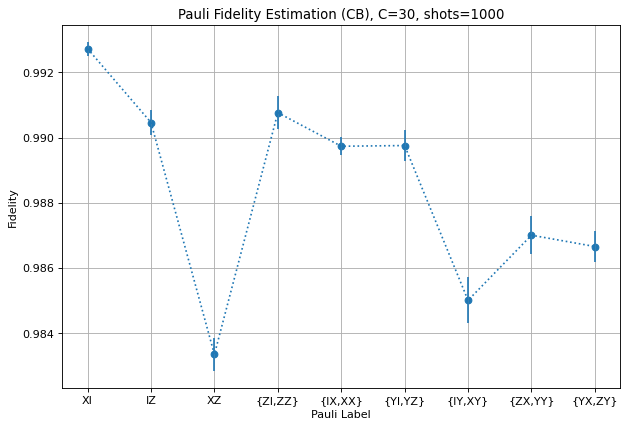

In [20]:
import numpy as np
import sys, json, copy, time, pickle, random
from concurrent.futures import ThreadPoolExecutor
import qiskit
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel, pauli_error, amplitude_damping_error, ReadoutError
import qiskit.ignis.verification.randomized_benchmarking as rb
# from qiskit.providers.aer.noise.errors.errorutils import single_qubit_clifford_gates
# from qiskit.providers.ibmq.managed import IBMQJobManager, ManagedJobSet
# sfrom qiskit.providers.ibmq.apiconstants import ApiJobShareLevel
from qiskit.qobj.utils import MeasLevel
from sympy import N
from qubit_map import qubit_maps
import matplotlib.pyplot as plt
from scipy.stats import sem, unitary_group
# from scipy import sparse
import CB_process
from statistics import stdev
import itertools
# from qiskit.compiler import transpile
from scipy.stats.mstats import gmean
#Change test

use_density_matrix = False # density matrix based / measurement based simulation


filename_label = 'ibmq_experiment_all_20220131_3792580001'
#filename_label = 'ibmq_experiment_all_20220131_3975437641'

with open('data/' + filename_label + '_result', 'rb') as infile:
    result = pickle.load(infile)




########### std_CB estimate
cb_fidelity_list = result['cb']['fidelity']
cb_stdev_list = result['cb']['stdev']

cb_deg_list1 = ['II','XI','IZ','XZ','{ZI,ZZ}','{IX,XX}','{YI,YZ}','{IY,XY}','{ZX,YY}','{YX,ZY}']
cb_deg_fidelity = {} 
cb_deg_stdev = {}
for label in deg_list1:
    if len(label) == 2:
        cb_deg_fidelity[label] = cb_fidelity_list[label]
        cb_deg_stdev[label] = cb_stdev_list[label]
    else:
        pp1 = label[1:3]
        pp2 = label[4:6]
        cb_deg_fidelity[label] = (cb_fidelity_list[pp1]+cb_fidelity_list[pp2])/2
        cb_deg_stdev[label] = np.sqrt(cb_stdev_list[pp1]**2 + cb_stdev_list[pp2]**2)


plt.figure(figsize=(9, 6), dpi=80)
n=2
plt.scatter(deg_list1,[cb_deg_fidelity[x] for x in deg_list1])
plt.errorbar(deg_list1,[cb_deg_fidelity[x] for x in deg_list1],[cb_deg_stdev[x] for x in deg_list1],ls=':')


# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
plt.title("Pauli Fidelity Estimation (std_CB), C=30, L=10, shots=1000")
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")



Text(0, 0.5, 'Fidelity')

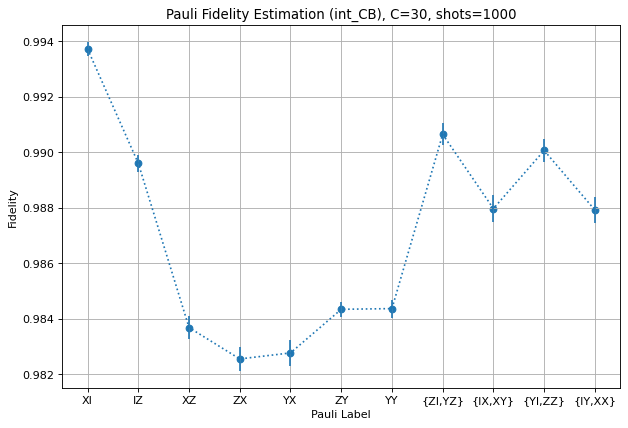

In [26]:
########### int_CB estimate
icb_fidelity_list = result['int_cb']['fidelity']
icb_stdev_list = result['int_cb']['stdev']

deg_list2 = ['XI','IZ','XZ','ZX','YX','ZY','YY','{ZI,YZ}','{IX,XY}','{YI,ZZ}','{IY,XX}']
icb_deg_fidelity = {} 
icb_deg_stdev = {}
for label in deg_list2:
    if len(label) == 2:
        icb_deg_fidelity[label] = icb_fidelity_list[label]
        icb_deg_stdev[label] = icb_stdev_list[label]
    else:
        pp1 = label[1:3]
        pp2 = label[4:6]
        icb_deg_fidelity[label] = (icb_fidelity_list[pp1]+icb_fidelity_list[pp2])/2
        icb_deg_stdev[label] = np.sqrt(icb_stdev_list[pp1]**2 + icb_stdev_list[pp2]**2)


plt.figure(figsize=(9, 6), dpi=80)
n=2
plt.scatter(deg_list2,[icb_deg_fidelity[x] for x in deg_list2])
plt.errorbar(deg_list2,[icb_deg_fidelity[x] for x in deg_list2],[icb_deg_stdev[x] for x in deg_list2],ls=':')


# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
plt.title("Pauli Fidelity Estimation (int_CB), C=30, L=10, shots=1000")
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")


In [ ]:
####### compare redundancy


In [29]:
####### use intercept information (Todo: Stdev analysis)
full_fidelity = {}
full_stdev = {}

full_fidelity['II'] = 1.0
for label in ['XI','IZ','XZ']:
    full_fidelity[label] = (cb_fidelity_list[label] + icb_fidelity_list[label])/2
    full_stdev[label] = np.sqrt(cb_stdev_list[label]**2 + icb_stdev_list[label]**2)
for label in ['ZX','YX','ZY','YY']:
    full_fidelity[label] = icb_fidelity_list[label]
    full_stdev[label] = icb_stdev_list[label]

full_fidelity['ZI'] = result['intc_cb']['dec_fidelity']['ZI']
full_fidelity['ZZ'] = result['intc_cb']['dec_fidelity']['ZZ']
full_fidelity['XX'] = result['intc_cb']['dec_fidelity']['XX']
full_fidelity['IX'] = result['intc_cb']['dec_fidelity']['IX']
full_fidelity['YZ'] = icb_deg_fidelity['{ZI,YZ}']/full_fidelity['ZI']
full_fidelity['YI'] = icb_deg_fidelity['{YI,ZZ}']/full_fidelity['ZZ']
full_fidelity['IY'] = icb_deg_fidelity['{IY,XX}']/full_fidelity['XX']
full_fidelity['XY'] = icb_deg_fidelity['{IX,XY}']/full_fidelity['IX']


Text(0, 0.5, 'Fidelity')

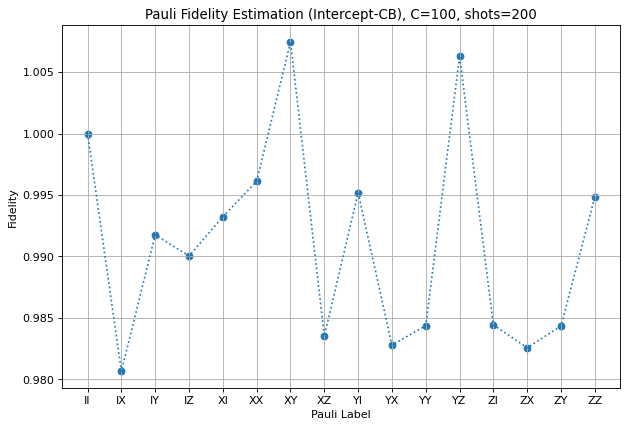

In [37]:
plt.figure(figsize=(9, 6), dpi=80)
n=2
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = n)]
# pauli_request_list = ['II','XI','IZ','XZ','ZI','ZZ','IX','XX','YI','YZ','IY','XY','ZX','YY','YX','ZY']

plt.scatter(pauli_request_list,list(full_fidelity[x] for x in pauli_request_list))
plt.errorbar(pauli_request_list,list(full_fidelity[x] for x in pauli_request_list),yerr = None,ls=':')

plt.grid(True)
plt.title("Pauli Fidelity Estimation (Intercept-CB), C=100, shots=200")
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")